In [2]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), "..", "..", "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
sys.path

['/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/few_shot_learning',
 '/opt/conda/lib/python38.zip',
 '/opt/conda/lib/python3.8',
 '/opt/conda/lib/python3.8/lib-dynload',
 '',
 '/home/blessyantony/.local/lib/python3.8/site-packages',
 '/opt/conda/lib/python3.8/site-packages',
 '/opt/conda/lib/python3.8/site-packages/IPython/extensions',
 '/home/blessyantony/.ipython',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/few_shot_learning/../../../../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/few_shot_learning/../../../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/few_shot_learning/../../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/few_shot_learning/../..']

In [3]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.metrics import roc_curve, accuracy_score, f1_score, auc, precision_recall_curve
from statistics import mean

from src.utils import utils, evaluation_utils, visualization_utils

In [4]:
output_file_path = os.path.join(os.getcwd(), "..","..", "..", "output/raw/uniref90_embl_vertebrates_non_idv/20240610/host_multi/few_shot_learning/fsl_non_idv_uniref90viridae_msl2048_transformer-l_6-h_8-d_1024-lr1e-4_classwise_auprc.csv")

In [5]:
df = pd.read_csv(output_file_path, index_col=0)

In [6]:
df

,class,auprc,itr
0,Blarina brevicauda,0.902020,0
1,Mastomys natalensis,0.829287,0
2,Peromyscus truei,0.928714,0
3,Anas castanea,0.799291,0
4,Centropristis striata,0.836425,0
...,...,...,...
295,Macaca fascicularis,0.625043,4
296,Melanogrammus aeglefinus,0.553542,4
297,Anas platyrhynchos,0.326740,4
298,Emberiza rustica,0.702536,4


In [15]:
classes = df["class"].sort_values().unique()
classes

array(['Acanthorhynchus tenuirostris', 'Acinonyx jubatus',
       'Ailuropoda melanoleuca', 'Ailurus fulgens', 'Ambystoma tigrinum',
       'Anas castanea', 'Anas platyrhynchos', 'Anas superciliosa',
       'Apodemus chevrieri', 'Arctocephalus australis',
       'Arctocephalus tropicalis', 'Blarina brevicauda', 'Bos taurus',
       'Cairina moschata', 'Callorhinus ursinus', 'Camelus dromedarius',
       'Capra hircus', 'Centropristis striata', 'Chelonia mydas',
       'Chenonetta jubata', 'Chimaera sp.',
       'Coelorinchus multispinulosus', 'Coendou prehensilis',
       'Corynorhinus rafinesquii', 'Crocodilurus amazonicus',
       'Crocodylus porosus', 'Cygnus columbianus', 'Desmodus rotundus',
       'Eidolon helvum', 'Elephas maximus', 'Emberiza chrysophrys',
       'Emberiza rustica', 'Emberiza spodocephala', 'Eptesicus serotinus',
       'Equus asinus', 'Equus caballus', 'Erinaceus europaeus',
       'Felis domesticus', 'Ficedula parva', 'Gallus gallus',
       'Gallus gallus dom

In [17]:
import math

def get_uniformly_divided_position_bins(positions, n_bins):
    bin_width = math.floor(len(positions)/n_bins)
    bins = []
    start = 0
    for i in range(n_bins):
        end = start + bin_width
        bins.append(positions[start:end])
        start = end
    return bins

<Figure size 432x288 with 0 Axes>

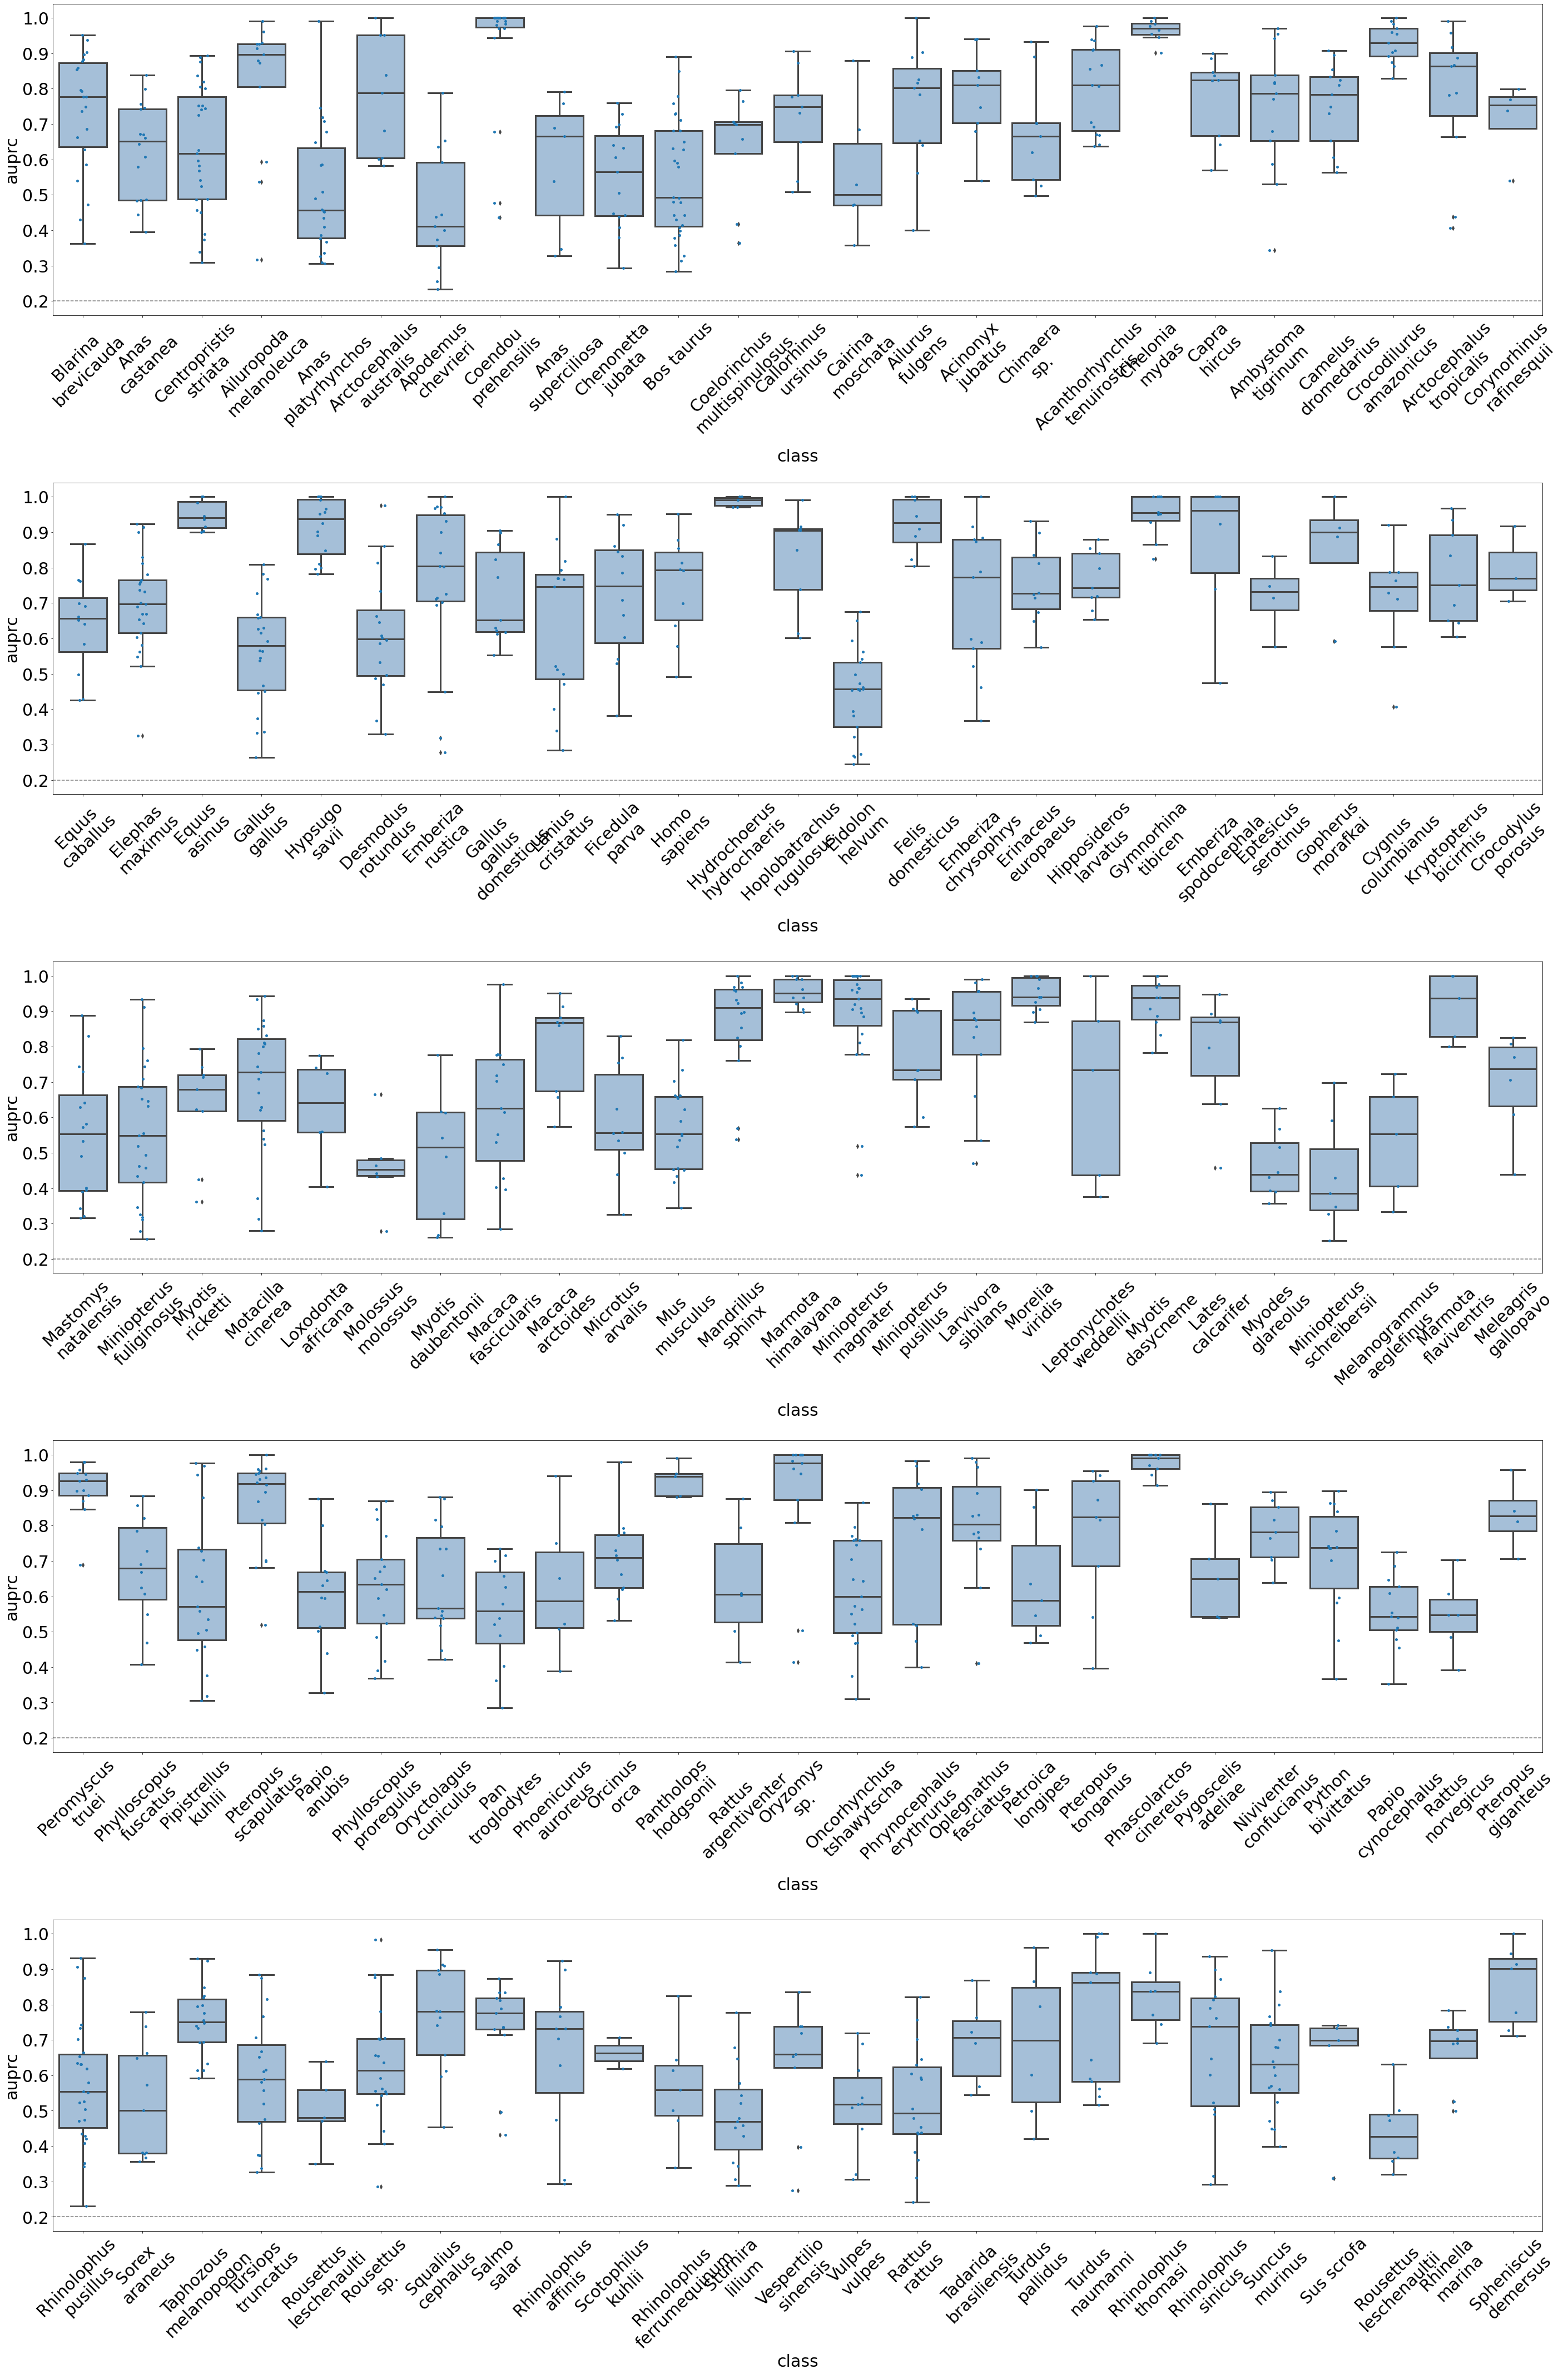

In [20]:
# plt.rcParams['xtick.labelsize'] = 15
# plt.rcParams['ytick.labelsize'] = 15


# DEFAULT_FIGURE_CONFIG = {
#     "figsize": (16, 8),
#     "xtick.labelsize": 15,
#     "ytick.labelsize": 15    
# }

plt.rcParams['figure.autolayout'] = True
plt.clf()
fig, axs = plt.subplots(5, 1, figsize=(40, 60), sharey=True)
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30
plt.rcParams.update({'font.size': 30})


bins = get_uniformly_divided_position_bins(list(classes), 5)

for i in range(5):
    sns.boxplot(data=df[df["class"].isin(bins[i])],  y="auprc", x="class", ax=axs[i], orient="v", 
                linewidth=3,
                boxprops={"facecolor": (.3, .5, .7, .5)})
    sns.stripplot(data=df[df["class"].isin(bins[i])], x="class", y="auprc", ax=axs[i])
    visualization_utils.wrap_ticklabels(axs[i], axis="x")
    axs[i].tick_params(axis='x', rotation=45)
    axs[i].axhline(0.2, color="gray", linestyle="--")

plt.show()


# visualization_utils.pre_plot_config(DEFAULT_FIGURE_CONFIG)
# ax = sns.boxplot(data=df, x="class", y="auprc")
# sns.stripplot(data=df, x="class", y="auprc", ax=ax)
# plt.draw()
# visualization_utils.wrap_ticklabels(ax, axis="x")